In [159]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


#data processing
import re, string
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB


#keras
import tensorflow as tf
from tensorflow import keras


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42



In [160]:
df = pd.read_csv('/kaggle/input/corona-dataset/Corona_NLP_train.csv',encoding='ISO-8859-1')
df_test = pd.read_csv('/kaggle/input/corona-dataset/Corona_NLP_test.csv')

In [161]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [163]:
df['TweetAt'] = pd.to_datetime(df['TweetAt'])

/tmp/ipykernel_42/1259316306.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['TweetAt'] = pd.to_datetime(df['TweetAt'])


In [164]:
df.drop_duplicates(subset='OriginalTweet',inplace=True)

In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       41157 non-null  int64         
 1   ScreenName     41157 non-null  int64         
 2   Location       32567 non-null  object        
 3   TweetAt        41157 non-null  datetime64[ns]
 4   OriginalTweet  41157 non-null  object        
 5   Sentiment      41157 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.9+ MB


In [166]:
tweets_per_day = df['TweetAt'].dt.strftime('%m-%d').value_counts().sort_index().reset_index(name='counts')

In [167]:
tweets_per_country = df['Location'].value_counts().loc[lambda x : x > 100].reset_index(name='counts')

In [168]:
df = df[['OriginalTweet','Sentiment']]

In [169]:
df_test = df_test[['OriginalTweet','Sentiment']]

In [170]:
!pip install demoji
import demoji



# Clean emojis from text using the demoji library
def strip_emoji(text):
    return demoji.replace(text, '')

# Remove punctuations, links, mentions, and \r\n new line characters
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower()  # Remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # Remove links and mentions
    text = re.sub(r'[^\x00-\x7f]', r'', text)  # Remove non utf8/ascii characters
    banned_list = string.punctuation + 'Ã' + '±' + 'ã' + '¼' + 'â' + '»' + '§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

# Clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))  # Remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet))  # Remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

# Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) or ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

# Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+", " ", text)

In [171]:
texts_new = []
for t in df.OriginalTweet:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))


# Now, texts_new contains the cleaned tweets


In [172]:
texts_new_test = []
for t in df_test.OriginalTweet:
    texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [173]:
df['text_clean'] = texts_new
df_test['text_clean'] = texts_new_test

In [174]:
df['text_clean'].head()

0                                              and and
1    advice talk to your neighbours family to excha...
2    coronavirus australia woolworths to give elder...
3    my food stock is not the only one which is emp...
4    me ready to go at supermarket during the covid...
Name: text_clean, dtype: object

In [175]:
df_test['text_clean'].head()

0    trending new yorkers encounter empty supermark...
1    when i couldnt find hand sanitizer at fred mey...
2    find out how you can protect yourself and love...
3    panic buying hits newyork city as anxious shop...
4    toiletpaper dunnypaper coronavirus coronavirus...
Name: text_clean, dtype: object

In [176]:
df['text_clean'][1:8].values

array(['advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order',
       'coronavirus australia woolworths to give elderly disabled dedicated shopping hours amid covid19 outbreak',
       'my food stock is not the only one which is empty please dont panic there will be enough food for everyone if you do not take more than you need stay calm stay safe covid19france covid19 covid19 coronavirus confinement confinementotal confinementgeneral',
       'me ready to go at supermarket during the covid19 outbreak not because im paranoid but because my food stock is litteraly empty the coronavirus is a serious thing but please dont panic it causes shortage coronavirusfrance restezchezvous stayathome confinement',
       'as news of the regions first confirmed covid19 case came out of sullivan county last week people 

In [177]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [178]:
df['text_len'] = text_len

In [179]:
text_len_test = []
for text in df_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

In [180]:
df_test['text_len'] = text_len_test

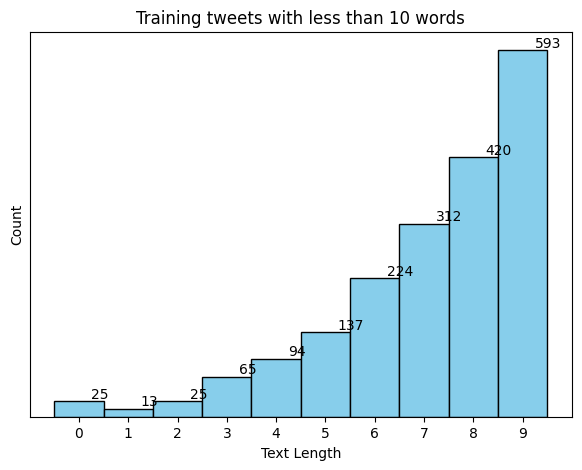

In [181]:
# Assuming df is your DataFrame
plt.figure(figsize=(7, 5))

# Filter the DataFrame for text lengths less than 10
filtered_df = df[df['text_len'] < 10]

# Create a histogram using Matplotlib
counts, bins, _ = plt.hist(filtered_df['text_len'], bins=range(11), color='skyblue', edgecolor='black', align='left')

# Add labels and title
plt.title('Training tweets with less than 10 words')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.xticks(bins[:-1])  # Set x-axis ticks to bin edges
plt.yticks([])

# Add count labels on top of the bars
for count, bin_edge in zip(counts, bins[:-1]):
    plt.text(bin_edge + 0.25, count, str(int(count)), va='bottom')

plt.show()

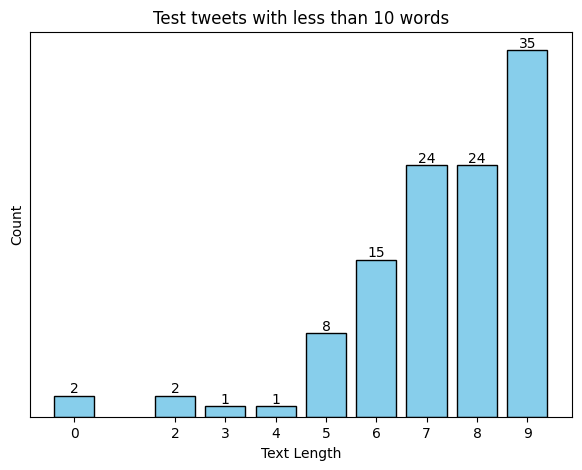

In [182]:
# Assuming df_test is your DataFrame
plt.figure(figsize=(7, 5))

# Filter the DataFrame for text lengths less than 10
filtered_df_test = df_test[df_test['text_len'] < 10]

# Create a bar plot using Matplotlib
ax = plt.bar(filtered_df_test['text_len'].value_counts().sort_index().index,
             filtered_df_test['text_len'].value_counts().sort_index(), color='skyblue', edgecolor='black')

# Add labels and title
plt.title('Test tweets with less than 10 words')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.xticks(filtered_df_test['text_len'].value_counts().sort_index().index)
plt.yticks([])

# Add count labels on top of the bars
for bar in ax:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, int(height), ha='center', va='bottom')

plt.show()

In [183]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (41157, 4)
 DF TEST SHAPE: (3798, 4)


In [184]:
df = df[df['text_len'] > 4]

In [185]:
df_test = df_test[df_test['text_len'] > 4]

In [186]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (40935, 4)
 DF TEST SHAPE: (3792, 4)


In [187]:
!pip install sentencepiece
import sentencepiece as spm

In [188]:

from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained('t5-base')

/opt/conda/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [189]:
token_lens = []

for txt in df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)

In [190]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 147


In [191]:
token_lens = []

for i,txt in enumerate(df['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 20, TEXT: we have amazing cheap deals for the covid2019 going on to help you trials monthly yearly and resonable prices subscriptions just dm us bestiptv iptv service iptv iptvdeals cheap iptv football hd movies adult cinema hotmovies iptvnew iptv2020 adult
INDEX: 21, TEXT: we have amazing cheap deals for the covid2019 going on to help you trials monthly yearly and resonable prices subscriptions just dm us bestiptv iptv service iptv iptvdeals cheap iptv football hd movies adult cinema hotmovies iptv iptvlinks 18movies
INDEX: 631, TEXT: the grocery store is out of most everythingcmon people get a fucking grip this is bullshitno tp paper towels or wipes for miles amp miles to be found may come down to using underwear amp going commando maryland aacounty coronavirus emptyshelves trump2020 wwg1wga q
INDEX: 645, TEXT: im fucking calling it now covid19 isnt gonna kill us since were all gonna kill eachother due to a fucking food shortage the panic is gonna go from a mere virus to a fuc

In [192]:
df['token_lens'] = token_lens

In [193]:
df = df.sort_values(by='token_lens', ascending=False)
df.head(20)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
37156,11 Nisan Cumartesi itibariyle ?BBÂnin tÃ¼m hi...,Neutral,11 nisan cumartesi itibariyle bbnin tm hizmetl...,39,147
1638,ZÃ¡sah policie proti spekulant?m s rouÂkami. ...,Neutral,zsah policie proti spekulantm s roukami na mj ...,39,139
16632,Bir mÃ¼ddettir sÃ¼permarketlerin lojistik hizm...,Neutral,bir mddettir spermarketlerin lojistik hizmeti ...,36,122
13691,Hoy aplaudo a mi segunda familia #AplaudoANues...,Neutral,hoy aplaudo a mi segunda familia aplaudoanuest...,38,109
34288,"$BRZL Scepter Holdings, Inc., Developing Hand ...",Positive,brzl scepter holdings inc developing hand sani...,36,109
10514,the new play Cannabis sales and prices are sky...,Positive,the new play cannabis sales and prices are sky...,41,107
4844,Impct of #coronavirus i hve sen hw civilizd pp...,Extremely Negative,impct of coronavirus i hve sen hw civilizd ppl...,48,106
7600,The dominos fall: #coronavirus &gt; world #h...,Extremely Positive,the dominos fall coronavirus gt world healthem...,44,106
35384,Safest Job in America is #Uninsured #SuperMark...,Extremely Positive,safest job in america is uninsured supermarket...,39,105
30206,#LDA City Lahore Residential Files Prices Upda...,Neutral,lda city lahore residential files prices updat...,43,104


In [194]:
df = df.iloc[12:]
df.head()

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
35512,Hand Sanitizer Gel type 500ml \r\r\nRM 55 \r\r...,Extremely Positive,hand sanitizer gel type 500ml rm 55 exd postag...,32,100
2825,"They say that"" The Fijian Competition and Cons...",Extremely Negative,they say that the fijian competition and consu...,46,97
23737,i wish i was the boss so i can scream ÂYOUR F...,Extremely Positive,i wish i was the boss so i can scream your fii...,35,96
28978,PM OF INDIA MR. NARENDREA MODI HAS TAKEN VERY ...,Negative,pm of india mr narendrea modi has taken very r...,33,96
9027,La escena se repite alrededor del mundo: desde...,Neutral,la escena se repite alrededor del mundo desde ...,38,95


In [195]:
df = df.sample(frac=1).reset_index(drop=True)

In [196]:
token_lens_test = []

for txt in df_test['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))

max_len=np.max(token_lens_test)

In [197]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 121


In [198]:
token_lens_test = []

for i,txt in enumerate(df_test['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 117, TEXT: hey guysss we have a very important message to all our friends family amp viewers out there be aware of corona virus and follow these procedures to help keep you and your family safe aadyasitara aadya sitara coronavrus coronaaleart covid19 staysafe sanitizer covid
INDEX: 159, TEXT: to all the people in the uk who are stock piling bog roll im pissed and its ur fault im running out and had to spend 11 on a pack when i normally pay 2 if u end up quarantined u will be at home w no food surrounded by bog roll coronavirus covid19 coronavirusoutbreak
INDEX: 284, TEXT: hey morons in sri lanka quit panicbuying perishables you absolute nitwitted fucknuggets nobody else is gonna have food and that loaf of bread is gonna be moldy as fuck by the end of the week also its more efficient to give sick people the masks use brains covid19
INDEX: 286, TEXT: so hard to decide as much as i want to hodl my 2 ccdcv4 token our place is declared to lock down due to covid19 i will use this to b

In [199]:
df_test['token_lens'] = token_lens_test

In [200]:
df_test = df_test.sort_values(by='token_lens', ascending=False)
df_test.head(10)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
345,Informoval jsem zástupce vech obchodních ?et?...,Neutral,informoval jsem zstupce vech obchodnch etzc o ...,31,121
2383,Ahora seguid llorando por el papel higiénico (...,Negative,ahora seguid llorando por el papel higinico qu...,44,114
286,@Rhett800cc So hard to decide??. As much as I ...,Negative,so hard to decide as much as i want to hodl my...,38,104
1485,DTF-Dont Touch Face\r\r\nDWBH-Do Wash Both Ha...,Extremely Negative,dtfdont touch face dwbhdo wash both hands gtfo...,42,99
525,$SPY GO OUT AND STOCK UP ON FOOD AND WATER PEO...,Extremely Positive,spy go out and stock up on food and water peop...,39,97
2688,Imagine if we had a president who had a plan f...,Extremely Negative,imagine if we had a president who had a plan f...,42,91
2466,#ohiocoronavirus #selfisolating #coronapocalyp...,Neutral,ohiocoronavirus selfisolating coronapocalypse ...,23,90
2602,"Stock up on Food, Water and supplements like S...",Extremely Positive,stock up on food water and supplements like se...,42,90
3505,Stop misusing ur privilege amp grow up Some1 c...,Positive,stop misusing ur privilege amp grow up some1 c...,57,89
2740,COVID-19: Your government will save ITSELF not...,Positive,covid19 your government will save itself not y...,43,89


In [201]:
df_test = df_test.iloc[5:]
df_test.head(3)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
2688,Imagine if we had a president who had a plan f...,Extremely Negative,imagine if we had a president who had a plan f...,42,91
2466,#ohiocoronavirus #selfisolating #coronapocalyp...,Neutral,ohiocoronavirus selfisolating coronapocalypse ...,23,90
2602,"Stock up on Food, Water and supplements like S...",Extremely Positive,stock up on food water and supplements like se...,42,90


In [202]:
df_test = df_test.sample(frac=1).reset_index(drop=True)

In [203]:
df['Sentiment'].value_counts()

Sentiment
Positive              11380
Negative               9889
Neutral                7561
Extremely Positive     6616
Extremely Negative     5477
Name: count, dtype: int64

In [204]:
df['Sentiment'] = df['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [205]:
df_test['Sentiment'] = df_test['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [206]:
df['Sentiment'].value_counts()

Sentiment
2    17996
0    15366
1     7561
Name: count, dtype: int64

In [207]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['Sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Sentiment']);

In [208]:
train_os['Sentiment'].value_counts()

Sentiment
0    17996
1    17996
2    17996
Name: count, dtype: int64

In [209]:
X = train_os['text_clean'].values
y = train_os['Sentiment'].values

In [210]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

In [211]:
X_test = df_test['text_clean'].values
y_test = df_test['Sentiment'].values

In [212]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [213]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [214]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 48589
VALIDATION DATA: 5399
TESTING DATA: 3787


In [215]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

In [216]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [217]:
nb_clf = MultinomialNB()

In [218]:
nb_clf.fit(X_train_tf, y_train_le)

MultinomialNB()

In [219]:
nb_pred = nb_clf.predict(X_test_tf)

In [220]:
print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test_le,nb_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.70      0.77      0.73      1629
     Neutral       0.60      0.43      0.50       614
    Positive       0.72      0.72      0.72      1544

    accuracy                           0.70      3787
   macro avg       0.67      0.64      0.65      3787
weighted avg       0.69      0.70      0.69      3787



In [221]:
MAX_LEN=128

In [222]:
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [223]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [224]:
token_lens = []

for txt in X_train:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length

100

In [225]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

def create_model_t5(t5_model, max_len=MAX_LEN):
    opt = Adam(learning_rate=5e-5, epsilon=1e-8)
    loss = CategoricalCrossentropy()
    accuracy = CategoricalAccuracy()

    input_ids = Input(shape=(max_len,), dtype='int32')
    attention_masks = Input(shape=(max_len,), dtype='int32')
    decoder_input_ids = Input(shape=(max_len,), dtype='int32')
    output = t5_model(input_ids=input_ids, attention_mask=attention_masks, decoder_input_ids=decoder_input_ids)
    output = GlobalAveragePooling1D()(output[0])
    output = Dense(3, activation='softmax')(output)
    model = Model(inputs=[input_ids, attention_masks, decoder_input_ids], outputs=output)
    model.compile(opt, loss=loss, metrics=[accuracy])

    return model


In [226]:
from transformers import TFT5Model

t5_model = TFT5Model.from_pretrained('t5-base')


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFT5Model.

All the weights of TFT5Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5Model for predictions without further training.


In [227]:
model = create_model_t5(t5_model , MAX_LEN)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_9 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None, 128)]                0         []                            
                                                                                                  
 tft5_model_1 (TFT5Model)    TFSeq2SeqModelOutput(last_   2229035   ['input_8[0][0]',             
                             hidden_state=(None, 128, 7   52         'input_9[0][0]',       

In [228]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

model_checkpoint = ModelCheckpoint(
    'model.h5',
    monitor='val_loss',
    save_best_only=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    min_lr=0.001
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)
# Shift the input_ids one position to the right to create decoder_input_ids
train_decoder_input_ids = np.roll(train_input_ids, shift=1, axis=-1)
val_decoder_input_ids = np.roll(val_input_ids, shift=1, axis=-1)

history = model.fit(
    [train_input_ids, train_attention_masks, train_decoder_input_ids],
    y_train,
    validation_data=([val_input_ids, val_attention_masks, val_decoder_input_ids], y_valid),
    epochs=4,
    batch_size=15,
    callbacks=[model_checkpoint, reduce_lr, early_stopping]
)

Epoch 1/4
3240/3240 [==============================] - ETA: 0s - loss: 0.5308 - categorical_accuracy: 0.7926

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3240/3240 [==============================] - 2773s 835ms/step - loss: 0.5308 - categorical_accuracy: 0.7926 - val_loss: 0.3863 - val_categorical_accuracy: 0.8652 - lr: 5.0000e-05
Epoch 2/4
3240/3240 [==============================] - 2708s 836ms/step - loss: 0.2926 - categorical_accuracy: 0.8959 - val_loss: 0.2959 - val_categorical_accuracy: 0.8976 - lr: 5.0000e-05
Epoch 3/4
3240/3240 [==============================] - 2708s 836ms/step - loss: 0.2010 - categorical_accuracy: 0.9284 - val_loss: 0.2540 - val_categorical_accuracy: 0.9200 - lr: 5.0000e-05
Epoch 4/4
3240/3240 [==============================] - 2691s 831ms/step - loss: 0.1320 - categorical_accuracy: 0.9557 - val_loss: 0.2673 - val_categorical_accuracy: 0.9246 - lr: 5.0000e-05


In [229]:
# Shift the input_ids one position to the right to create decoder_input_ids
test_decoder_input_ids = np.roll(test_input_ids, shift=1, axis=-1)

# Now you can use these as inputs to the model
result_T5 = model.predict([test_input_ids, test_attention_masks, test_decoder_input_ids])


119/119 [==============================] - 69s 529ms/step


In [230]:
y_pred_T5 = np.zeros_like( result_T5)
y_pred_T5[np.arange(len(y_pred_T5)), result_T5.argmax(1)] = 1

In [232]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from math import sqrt

# Calculate MSE
mse = mean_squared_error(y_test,y_pred_T5)

# Calculate RMSE
rmse = sqrt(mse)

# Print classification report, MSE and RMSE
print('\tMean Squared Error: ', mse)
print('\tRoot Mean Squared Error: ', rmse)
print('\n')
# Calculate accuracy
accuracy = accuracy_score(y_test,y_pred_T5)

# Print classification report and accuracy
print('\tClassification Report for T5base:\n\n', classification_report(y_test,y_pred_T5, target_names=['Negative', 'Neutral', 'Positive']))
print('\tAccuracy: ', accuracy)

	Mean Squared Error:  0.08485168559105712
	Root Mean Squared Error:  0.29129312657709094


	Classification Report for T5base:

               precision    recall  f1-score   support

    Negative       0.86      0.90      0.88      1629
     Neutral       0.88      0.76      0.81       614
    Positive       0.88      0.89      0.89      1544

   micro avg       0.87      0.87      0.87      3787
   macro avg       0.87      0.85      0.86      3787
weighted avg       0.87      0.87      0.87      3787
 samples avg       0.87      0.87      0.87      3787

	Accuracy:  0.8727224716134143
